In [1]:
# 2022.01.03/ tf: 2.7.0, cuda: 11.2, cudnn: 11.x match
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import os
import math

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
os.getcwd()

'c:\\Users\\simjh96\\myFarm\\learning'

In [4]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back),:]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

    
df = pd.read_csv(r'../data/top1.csv')
df = df.set_index('saleDate')
top1_arr = df.to_numpy()

# fix random seed for reproducibility
np.random.seed(1)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(top1_arr.reshape([-1,1]))

# split into train and test sets
train_size = int(len(dataset) * 0.67) 
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

# reshape into X=t and Y=t+1
look_back = 28
trainX, trainY = create_dataset(train, look_back)  
testX, testY = create_dataset(test, look_back)

# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, 1))
testX = np.reshape(testX, (testX.shape[0],look_back, 1))

In [ ]:
from keras import backend as K
K.clear_session()

Epoch 1/20
17/17 [==============================] - 2s 98ms/step - loss: 0.0210 - val_loss: 0.0042
Epoch 2/20
17/17 [==============================] - 1s 76ms/step - loss: 0.0067 - val_loss: 0.0061
Epoch 3/20
17/17 [==============================] - 1s 80ms/step - loss: 0.0056 - val_loss: 0.0038
Epoch 4/20
17/17 [==============================] - 1s 79ms/step - loss: 0.0049 - val_loss: 0.0035
Epoch 5/20
17/17 [==============================] - 1s 77ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 6/20
17/17 [==============================] - 1s 82ms/step - loss: 0.0037 - val_loss: 0.0027
Epoch 7/20
17/17 [==============================] - 1s 78ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 8/20
17/17 [==============================] - 1s 80ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 9/20
17/17 [==============================] - 2s 101ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 10/20
17/17 [==============================] - 2s 110ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 1

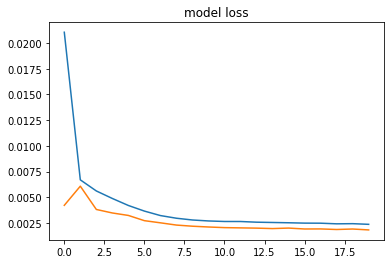

In [6]:
# create and fit the LSTM network

model = Sequential()
model.add(LSTM(4, input_shape=(look_back,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history= model.fit(trainX, trainY,validation_split=0.33, epochs=20, batch_size=32)

# Plot training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.show()

In [8]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# inverse transform has to match dimention for fit(input)
# fit(1220,1) -> inverse_fit(788,1)
# Inverse transform it and select the 
trainPredict = scaler.inverse_transform(trainPredict)[:,0]

# Inverse transform it and select the 
testPredict = scaler.inverse_transform(testPredict)[:,0]   

In [12]:
# Y is shaped (788,) need (788,1)
trainY = scaler.inverse_transform(trainY[..., np.newaxis])[:, 0]
testY = scaler.inverse_transform(testY[..., np.newaxis])[:, 0]

In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, 0] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2) +
                1:len(dataset)-1, 0] = testPredict


Train Score: 152.09 RMSE
Test Score: 241.63 RMSE


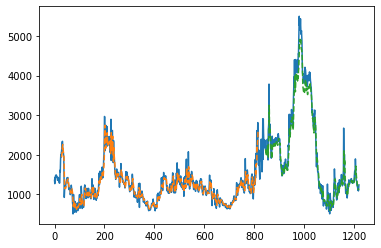

In [ ]:
plt.plot(scaler.inverse_transform(dataset)[:,0])  
plt.plot(trainPredictPlot[:,0],linestyle='--')
plt.plot(testPredictPlot[:,0],linestyle='--')